# Application of RKS algorithm for multi-class classification

## Introduction

In this notebook, we describe a method in order to use the efficient RKS algorithm for many class classification. The method we propose is to transform the problem into a *tensor product of binary classification problems*.

For this task, we consider the <a href="https://en.wikipedia.org/wiki/Gray_code">Gray code</a> of each class. For example, the class $2$ becomes the class $11$, $3$ becomes $10$. The justification for such an approach is that it minimizes the distance between two neighboring classes in the sense that the code changes only by one digit at each time.

Afterwards, the Gray code is transformed into a sequence of $1$'s and $-1$'s. More precisely, $1$ in the code remains $1$; whereas $0$ becomes $-1$. For instance, the class $2$ becomes the class $[1, 1]$ and the class $3$ becomes the class $[-1, 1]$. The idea is to use the strings of $1$'s and $-1$'s in order to define many classification problems. Our new code will be called hereafter the *binary Gray code*.

One first remark is that this method is quite efficient. As a matter of fact, our initial problem becomes $\lceil \lg(n_c) \rceil$ binary classification problems, where $n_c$ is the number of classes. Of course, those problems will be solved by the RKS algorithm.

For the sake of simplicity, we only consider multi-class linear classification problems. Each of these problems becomes $\lceil \lg(n_c) \rceil$ binary linear classification problems.

We would like to stress that one advantage of the method is that it relies on the repetition of a binary linear classification, hence its simplicity. Moreover, the number of binary classifications increases logarithmically with the number of classes.

#### Another justification for the Gray code approach

One argument justifying the usage of teh Gray code instead of the binary code is that it is more natural. For example, let us suppose that we are faced with a four class problem. If these classes are defined in a trigonometric or anti-trigonometric fashion, then the linear classification problems become easy as shown in this figure:

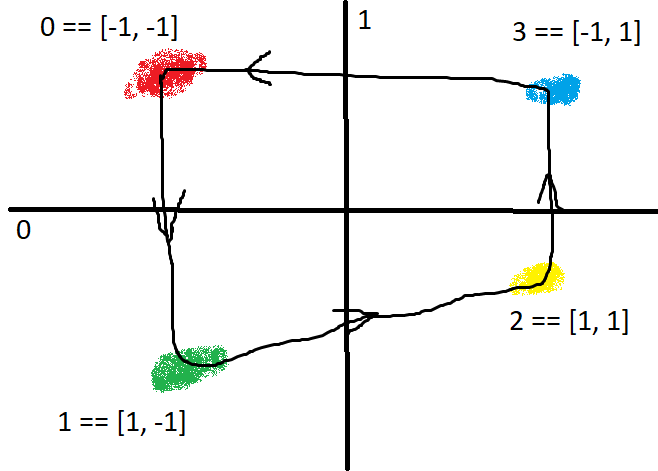


#### Intuition of our method

Before diving into the Python implementation of our method, we believe that an intuition should be presented.

Let us start by considering the case of a binary classification. The RKS algorithm, depending on the value of $R$ and $\gamma$, classifies $\mathbb{R}^2$ in a fashion that looks more or less like:

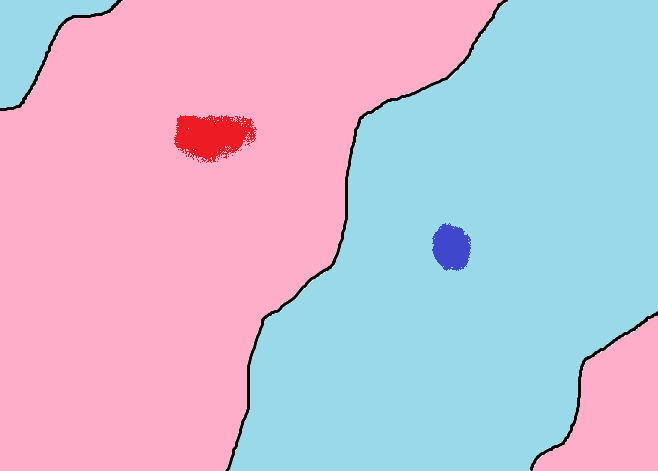

If, instead of $2$ classes, we had to classify the data set into $4$ classes, we would apply two binary classifications, each for each coordinate of the binary Gray code. We would obtain the following result:

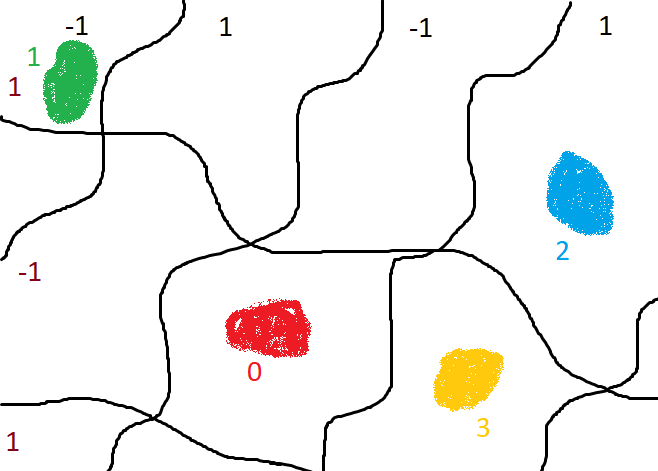

As one can remark, the classification is the result of a tensor product of $2$ binary linear classifications. One consequence of our method is that the resulting classification of $\mathbb{R}^2$ is a grid of the different classes. Of course, such a classification is absurd. However, as far as the classification of the data set is concerned, the method can give good results since it defines the "zone" of each class.

This intuition can be seen in the following actual classification cell, where the grid has been drawn in black lines:
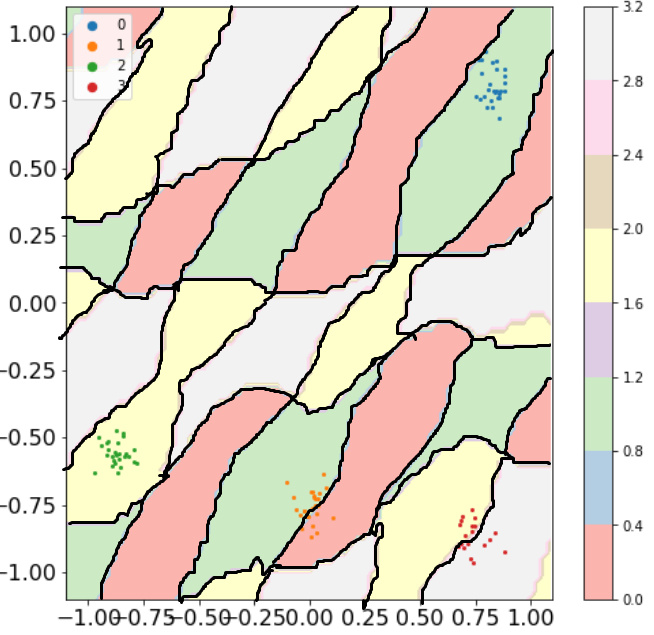

However, more generally, the tensor product is not as easy to be seen by the "naked eye", in particular if we consider classification problems with a greater number of classes. Nevertheless, the grid intuition remains true.

#### Relabeling

After defining the grid, we use a step of relabeling. This step is justified by the empirical observation that, sometimes, the classification manages to put each cluster into different cells of the grid, but wth mislabeling. As a matter of fact, the grid structure implies that the different clusters become entangled, thus the classification of one cluster influences the classification of the other cells.  We thought that we could levrage this observation in order to relabel the cells using a yet unused subset of the data set, hence relatively disentangling the different clusters.

## Python implementation

We start by redefining the elements that we used in the RKS notebook.

In [23]:
import numpy as np
import perceval as pcvl
import perceval.lib.phys as phys
from math import comb
import sklearn.datasets as skdt
import time
from scipy.optimize import basinhopping
from copy import deepcopy
import matplotlib.pyplot as plt
import pybobyqa
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier

In [24]:
h = .03    # step size in the mesh
m = 2 # number of modes
n = 10 # number of photons
alpha=5e-5 # regularization parameter - avoid singular matrix
input_state = pcvl.BasicState([n, 0]) # |n, 0>
x_ri = pcvl.P("x_ri") # parameter x_r,i = gamma * (w_r . x_i + b_r)

In [25]:
simulator_backend = pcvl.BackendFactory().get_backend("SLOS") # definition of the backend
s1 = simulator_backend(pcvl.Matrix.random_unitary(m)) # some matrix that will be changed later
s1.compile(input_state) 
c = phys.BS() // (0, phys.PS(x_ri)) // phys.BS() # cicruit definition
pcvl.pdisplay(c) # graphical representation

In [26]:
def quantum_value(xRI, lambda_random):
    """
    Wrapper that define the quantum circuit computation
    """
    x_ri.set_value(xRI % (2 * np.pi)) # set the new phase of the phase shifter
    U = c.compute_unitary(use_symbolic=False) # define the new circuit matrix
    s1.U = U # modify the unitary matrix of the simulator
    return np.sum(np.multiply(s1.all_prob(input_state), 1e6 * lambda_random)) # observable computation

In [27]:
lambda_random =np.array([ 5.13485653,  3.99435195,  3.37915661,  2.03162364, -0.49679927,  2.07146846,
                -1.81354477, -2.30534346, -2.79139468, -4.17917937, -5.12995055])

In [28]:
def random_parameter(name_law, d = 2):
    """
    sets a new value to the x_{r,i} parameter
    
    Symmetry of the Fourier transform is not required since the real part is already taken 
    (we use cosines instead of complex exponentials).
    >> d: dimension of the vector d
    >> Available names (name_law):
    
        - exponential: np.random.exponential(size = d)
        - chisquare: np.random.chisquare(1, size = d)
        - beta: np.random.beta(2, 2, size = d)
        - lognormal: np.random.lognormal(size = d)
        - logistic: np.random.logistic(size = d)
        - laplace: np.random.laplace(size = d)
        - gamma: np.random.gamma(2, size = d)
        - triangular: np.random.triangular(-1, 1, size = d)
        - cauchy: np.random.standard_cauchy(size = d)
        - pareto: np.random.pareto(1, size = d)
        - normal: np.random.normal(size = d)
        - vonmises: np.random.vonmises(0, 4, size = d)
        - uniform: np.random.uniform(low=-1, high=1, size = d)
        - wald: np.random.wald(3, 2, size = d)
        - weibull: np.random.weibull(5, size = d)
        - student: np.random.standard_t(1, size = d)
        - f (Fisher-Snedecor): np.random.f(100, 100, size = d)
    """
    
    # omega definition
    if name_law == "exponential":
        w_r = np.random.exponential(size = d) 
    elif name_law == "chisquare":
        w_r = np.random.chisquare(1, size = d)
    elif name_law == "beta":
        w_r = np.random.beta(2, 2, size = d)
    elif name_law == "lognormal":
        w_r = np.random.lognormal(size = d)
    elif name_law == "logistic":
        w_r = np.random.logistic(size = d)
    elif name_law == "laplace":
        w_r = np.random.laplace(size = d)
    elif name_law == "gamma":
        w_r = np.random.gamma(2, size = d)
    elif name_law == "triangular":
        w_r = np.random.triangular(-1, 0,  1, size = d)
    elif name_law == "cauchy":
        w_r = np.random.standard_cauchy(size = d)
    elif name_law == "pareto":
        w_r = np.random.pareto(1, size = d)
    elif name_law == "normal":
        w_r = np.random.normal(size = d)
    elif name_law == "vonmises":
        w_r = np.random.vonmises(0, 4, size = d)
    elif name_law == "uniform":
        w_r = np.random.uniform(low=-1, high=1, size = d)
    elif name_law == "wald":
        w_r = np.random.wald(3, 2, size = d)
    elif name_law == "weibull":
        w_r = np.random.weibull(5, size = d)
    elif name_law == "student":
        w_r = np.random.standard_t(1, size = d)
    elif name_law == "f":
        w_r = np.random.f(100, 100, size = d)
    else:
        raise("Value Error: Law name undefined")
        
    b_r = np.random.uniform(0, 2 * np.pi)
    return w_r, b_r


### Data generation

We generate the data set through the function ```sklearn.datasets.make_blobs```. Since the binary Gray code is a universal code, we generate the binary Gray code dictionary during the data generation process. First, we compute the actual Gray code thanks to already defined functions. Afterwards, we apply the transformation defined in the introduction. The result of these computation is used to define a global dictionary ```dict_class``` that links the classes to their binary Gray code and vice-versa.

In [29]:
def binarytog(n):
    """
    Converts the binary representation into Gray code.
    """
    n = int(n, 2) # convert to int
    n ^= (n >> 1)
 
    # bin(n) returns n's binary representation with a '0b' prefixed
    # the slice operation is to remove the prefix
    return bin(n)[2:]

def redef_class(n):
    """
    Computes the Gray code of the different classes and fills the conversion into a dictionary.
    """
    res=dict()
    n_log=int(np.ceil(np.log2(n)))
    for k in range(int(2**n_log)):
        str_k=binarytog(format(k, "b"))
        to_add=[]
        for i in range(-1, -1-len(str_k), -1):
            if str_k[i] == "0":
                to_add.append(-1)
            else:
                to_add.append(1)
        for i in range(len(str_k), n_log):
            to_add.append(-1)
        # in order to be able to read in both directions
        res[k] = deepcopy(to_add)
        res[str(deepcopy(to_add))] = k
    return res

def generate_data(N, n_c, noise_param):
    """
    Generate n_c blobs formed by a total of N points.
    noise_param defines the clusters standard deviations.
    """
    
    def normalizeX(z):
        """
        Sets the values between -1 and 1 linearly
        """
        zmax = np.max(z)
        zmin = np.min(z)
        return 2 * (z - zmin) / (zmax - zmin) - 1
    
    def normalizey(z):
        """
        Calls the function redef_class so as to define the dictionary of classes - binary Gray code and converts
        the label vector accordingly
        """
        global dict_class
        dict_class=redef_class(n_c)
        res = []
        for i in range(len(z)):
            res.append(deepcopy(dict_class[z[i]]))
        return np.array(res)
        
    X, y=skdt.make_blobs(n_samples=N, n_features=2,centers=n_c, cluster_std=noise_param)
    return normalizeX(X), normalizey(y)

### Linear Algebra Operations

We define the same linear operations as those used in the RKS notebook. However, we add a function that calls upon the different $c_{opt}$ vectors from each of the classification problems and computes the corresponding classification using the global dictionary ```dict_class```.

In [30]:
def q_z(X):
    """
    Defines the vector containing the different Fourier terms with the correct normalization
    """
    res = []
    for r in range(R):
        res.append(quantum_value(gamma * (np.dot(w[r], X) + b[r]), lambda_random))  # x_r,i = gamma * (w_r . x_i + b_r)
    return np.array(res) / np.sqrt(R) # normalization

def qZ(X):
    """
    Defines the matrix z(X) from the Fourier feature vectors
    """
    res = []
    for i in range(len(X)):
        res.append(q_z(X[i])) # this way of defining the matrix computes the transposition directly
    return np.array(res) / np.sqrt(R) # normalization

def c_opt(mat_Z, y):
    """
    Defines the resolution of the linear system.
    
    Inputs: z(X) matrix and the training label vector y
    """
    mat_Z_t = np.transpose(mat_Z)
    return np.linalg.solve(mat_Z_t @ mat_Z + alpha * np.eye(R), mat_Z_t @ y)

def q_classifier(c_opt_val, x):
    """
    Defines the classifier that is linear in the Fourier feature space.
    We still have to take the sign in order to get the actual classification.
    """
    return np.dot(c_opt_val, q_z(x)) # inner product between c_opt and z(x)

def Q_Classifier(c_opt_val_list, x):
    """
    A wrapper that calls q_classifier in order to apply linear classification for each dimension of the binary Gray code.
    Q_Classifier uses the global dictionary redef in order to use the new labels.
    """
    res_class=[]
    for i in range(len(c_opt_val_list)):
        res_class.append(int(np.sign(q_classifier(c_opt_val_list[i], x))))
    return redef[dict_class[str(res_class)]]

### Score computation

For the sake of simplicity, we decided to take a hard score definition, i.e. we only count the portion of the test database where the classifier got it *exactly* right. However, since our classifier relies on the repeated use of a binary classifier, we take the $\lceil \lg(n_c) \rceil$ root of the score. Indeed, if our classifier used the binary Gray representation naively, the hard score would be $0.5^{\lceil \lg(n_c) \rceil}$. Therefore, in order to get a score always representing the "same thing", we cancel the power by taking the corresponding root. It may be noted that we are actually underestimating the performance of our classifier since we do not take into account the partially correct classification.

In [31]:
def q_score(X, y, c_opt_val_list): # quantum score
    """
    Computes the score over the given set X and labels y using the given c_opt vector.
    """
    cpt = 0
    print(">>> Scoring")
    for i in tqdm(range(len(X))):
        if Q_Classifier(c_opt_val_list, X[i]) == dict_class[str(list(y[i]))]: cpt += 1
    return cpt / len(X)

### Redefining labels

The function below defines the relabeling process mentioned above. It uses the following greedy approach. For each classification result or label, obtained using the "grid" classification, we change the label into the actual label of the plurality of the points asigned the aforementioned label, i.e.

\begin{equation*}
 \tilde{y_k} = argmax_{y \in setClass}\{|\{X_i \ ; \ class(X_i) = y_k \ and \ y_i = y\}|\}
\end{equation*}

where $class$ is the grid classification function, $y_k$ is the current classification label and $\tilde{y_k}$ is the new label.

In [32]:
def relab(X, y, c_opt_val_list):
    """
    Redefines the labels corresponding to the different binary Gray vectors through a
    greedy approach.
    """
    global redef
    redef = dict()
    n_size = len(dict_class) // 2
    counts = np.zeros((n_size, n_size))
    for k in range(n_size): # initial definition: we keep the initial label
        redef[k] = k
    print(">>> Relabeling")
    for i in tqdm(range(len(X))):
        counts[Q_Classifier(c_opt_val_list, X[i]), dict_class[str(list(y[i]))]] += 1
    argmaxes = np.argmax(counts, axis=1) 
    for k in range(n_size):
        redef[k] = argmaxes[k] # greedy approach: take the best new label

### Graphical representation

In [33]:
def classes(y):
    """
    Reconverts the label vector into the integer form. It is applied on the actual labels, hence no need
    to use relabeling.
    """
    return np.array([dict_class[str(list(y[i]))] for i in range(len(y))])

def plot_q_classification(X, y, c_opt_val_list, ret, n_c):
    """
    Defines the graphical representation which contains some points and their corresponding labels,
    the background is the classification of the square [-1.1, 1.1] x [-1.1, 1.1] and the score (given
    in the input) written in the title.
    """
    global dict_class
    plt.figure(figsize=(8,8))# Generate figure

    # create a mesh for the background
    xx = np.arange(-1.1, 1.1, h)
    yy = np.arange(-1.1, 1.1, h)
    zs = np.zeros((len(xx), len(yy)))
    print(">>> Plotting")
    for i in tqdm(range(len(xx))):
        for j in range(len(yy)):
            zs[i, j] = Q_Classifier(c_opt_val_list, np.array([xx[i], yy[j]]))
    cs = plt.contourf(xx, yy, zs, cmap="Pastel1")
    plt.colorbar()

    # Plot scatter points
    Y = classes(y)
    for it in range(n_c): # number of classes
        plt.scatter(
            X[Y== it, 1],
            X[Y == it, 0],
            s=4,
            label=str(it),
            alpha=1
        )

    plt.xlabel('x', fontsize=18)
    plt.ylabel('y', fontsize=18)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    lgnd = plt.legend(fontsize=10)

    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    for it in range(n_c):
        lgnd.legendHandles[it]._sizes = [40]
    plt.title("score = " + str(ret))  # write the score in the title
    plt.show()

### Wrapper

As usual, we define a wrapper that calls the functions we defined previously. However, some remarks should be made concerning the values of $R$ and $\gamma$:

1. The value of $\gamma$ defines the resolution of the classifier. Its value is defined by the value of ```noise_param``` defined by $\gamma = \frac{2.5}{np}$, where $np$ stands for ```noise_param```. The value was found empirically.
2. Since we make a tensor product of linear classification: R ought to keep the same value. Through trial and error, we find the following value: $R = 20$.

Moreover, by contrast to the RKS notebook, the quality of our classification depends on the probability law generating the kernel. This is due to the relatively large values of $\gamma$ ($50$ times larger than in the RKS notebook). The input values are larger and reach ranges where the errors in the estimated kernels and their relative differences matter. Therefore, we chose to only use the normal law, which yields a Gaussian kernel.

In [34]:
def q_fit(N=1000, n_c=4, noise_param=.5):
    """
    Wrapper that uses a prepared quantum kernel in order to call all the classification steps:
    1. Fourier spectrum definition, R redefinition and data generation using noise_param if not noise_param is None
    2. Definition of c_opt by resolving the linear system
    3. Relabeling
    4. Score computation
    5. Graphical representation
    """
    global R, w, b, gamma, dict_class
    gamma = 2.5 / noise_param  # scale depends on the size of the generated data set
    R = 20
    c_opt_val_list = []
    
    X, y = generate_data(N, n_c, noise_param)  # data generation - noise redefinition
    # divide dataset into train, test, graphical
    prop1 = int(0.8 * len(y))
    prop2 = int(0.9 * len(y))
    
    print(">>> Directional classification learning")
    for i in tqdm(range(len(dict_class[0]))): # classification for each direction
        w = []
        b = []
        for _ in range(R):
            temp1, temp2 = random_parameter("normal")
            w.append(temp1)
            b.append(temp2)
        
        c_opt_val_list.append(c_opt(qZ(X[:prop1]), y[:prop1, i])) # train in order to learn c_opt
    relab(X[prop1:prop2], y[prop1:prop2], c_opt_val_list) # changing labels
    # score computation + taking the root
    ret = pow(q_score(X[prop2:], y[prop2:], c_opt_val_list), 1 / len(dict_class[0])) 
    print("\n>>>>>> quantum score = ", ret)
    plot_q_classification(X[prop2:], y[prop2:], c_opt_val_list, ret,n_c) # graphical representation
    return ret

## Examples

In the light of the following examples, one can arrive to the following conclusions:

1. The quality of the fitting depends *greatly* on the relative positions of the different clusters. This fact stems from the squaring of $\mathbb{R}^2$. If the clusters are positioned badly, the data structure may be too "complex" to be represented by a simple grid. This is a default of our approach.
2. It is hugely sub-optimal not to use all the $2^{\lceil \lg(n_c) \rceil}$ binary Gray classes. In particular, it adds potential classes into which some test points may be classified (without corresponding to any real class). This phenomenon is very commun as shown by our intuition of the method. If your data set does not have a number of classes which is equal to a power of $2$, you can either merge or split classes.

>>> Directional classification learning


100%|██████████| 1/1 [00:12<00:00, 12.88s/it]


>>> Relabeling


100%|██████████| 100/100 [00:01<00:00, 54.44it/s]


>>> Scoring


100%|██████████| 100/100 [00:01<00:00, 58.18it/s]



>>>>>> quantum score =  1.0
>>> Plotting


100%|██████████| 74/74 [01:28<00:00,  1.20s/it]


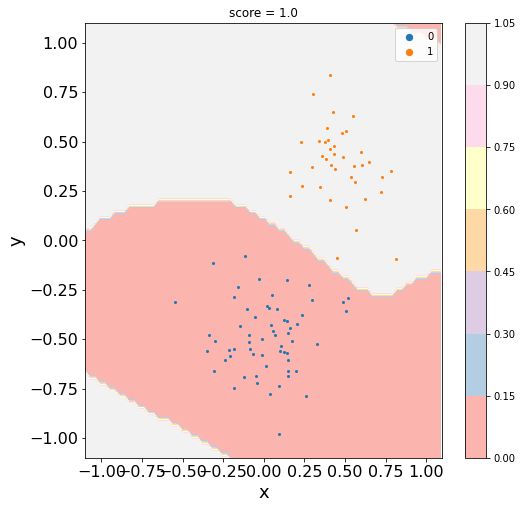

1.0

In [13]:
q_fit(n_c=2, noise_param=3)

>>> Directional classification learning


100%|██████████| 2/2 [00:25<00:00, 12.86s/it]


>>> Relabeling


100%|██████████| 100/100 [00:03<00:00, 30.90it/s]


>>> Scoring


100%|██████████| 100/100 [00:03<00:00, 29.84it/s]



>>>>>> quantum score =  0.99498743710662
>>> Plotting


100%|██████████| 74/74 [02:54<00:00,  2.36s/it]


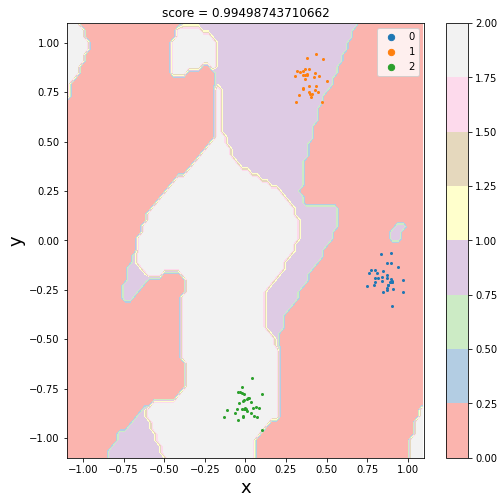

0.99498743710662

In [17]:
q_fit(n_c=3)

>>> Directional classification learning


100%|██████████| 2/2 [00:26<00:00, 13.03s/it]


>>> Relabeling


100%|██████████| 100/100 [00:03<00:00, 27.85it/s]


>>> Scoring


100%|██████████| 100/100 [00:03<00:00, 28.37it/s]



>>>>>> quantum score =  0.9797958971132712
>>> Plotting


100%|██████████| 74/74 [03:01<00:00,  2.46s/it]


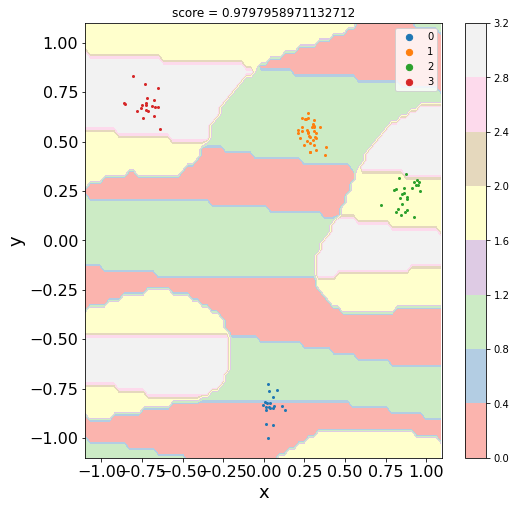

0.9797958971132712

In [15]:
q_fit()

>>> Directional classification learning


100%|██████████| 2/2 [00:25<00:00, 12.71s/it]


>>> Relabeling


100%|██████████| 100/100 [00:03<00:00, 29.14it/s]


>>> Scoring


100%|██████████| 100/100 [00:03<00:00, 29.52it/s]



>>>>>> quantum score =  0.9055385138137416
>>> Plotting


100%|██████████| 74/74 [02:54<00:00,  2.36s/it]


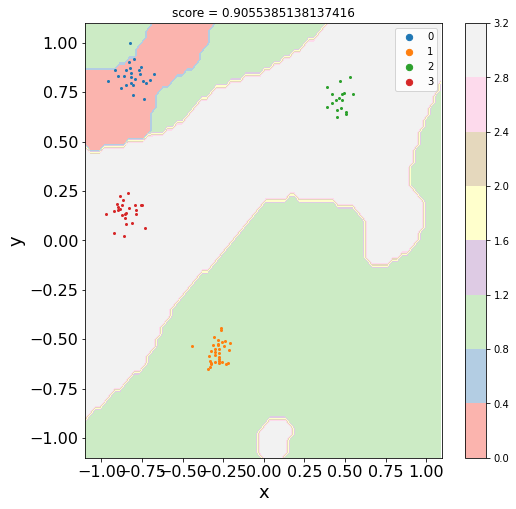

0.9055385138137416

In [16]:
q_fit()

>>> Directional classification learning


100%|██████████| 2/2 [00:25<00:00, 12.62s/it]


>>> Relabeling


100%|██████████| 100/100 [00:03<00:00, 30.22it/s]


>>> Scoring


100%|██████████| 100/100 [00:03<00:00, 30.32it/s]



>>>>>> quantum score =  1.0
>>> Plotting


100%|██████████| 74/74 [02:53<00:00,  2.35s/it]


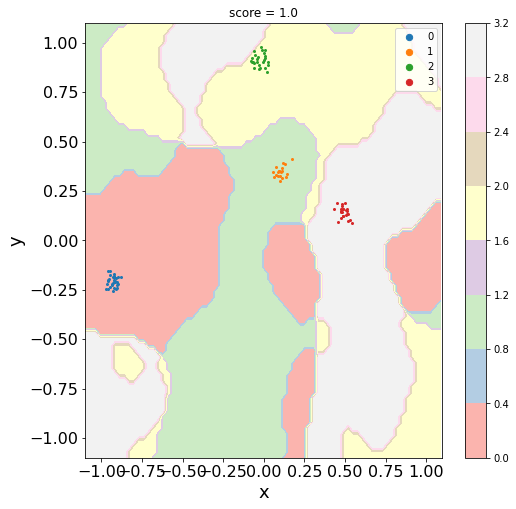

1.0

In [24]:
q_fit(noise_param=.3)

>>> Directional classification learning


100%|██████████| 2/2 [00:26<00:00, 13.03s/it]


>>> Relabeling


100%|██████████| 100/100 [00:03<00:00, 28.84it/s]


>>> Scoring


100%|██████████| 100/100 [00:03<00:00, 28.64it/s]



>>>>>> quantum score =  0.9643650760992956
>>> Plotting


100%|██████████| 74/74 [02:56<00:00,  2.38s/it]


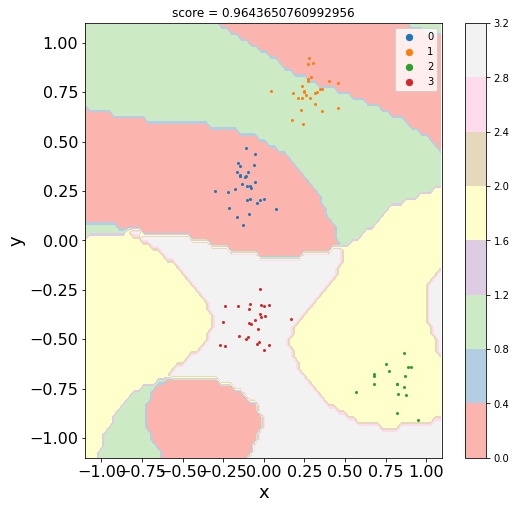

0.9643650760992956

In [29]:
q_fit(noise_param=1)

>>> Directional classification learning


100%|██████████| 3/3 [00:38<00:00, 12.82s/it]


>>> Relabeling


100%|██████████| 100/100 [00:05<00:00, 19.80it/s]


>>> Scoring


100%|██████████| 100/100 [00:05<00:00, 19.39it/s]



>>>>>> quantum score =  0.9004113346093702
>>> Plotting


100%|██████████| 74/74 [04:24<00:00,  3.58s/it]


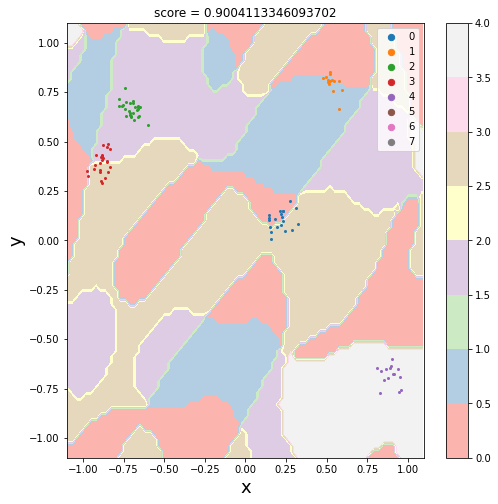

0.9004113346093702

In [40]:
q_fit(n_c=5)

>>> Directional classification learning


100%|██████████| 3/3 [00:39<00:00, 13.06s/it]


>>> Relabeling


100%|██████████| 100/100 [00:04<00:00, 20.36it/s]


>>> Scoring


100%|██████████| 100/100 [00:04<00:00, 20.00it/s]



>>>>>> quantum score =  0.9125805270773933
>>> Plotting


100%|██████████| 74/74 [04:25<00:00,  3.59s/it]


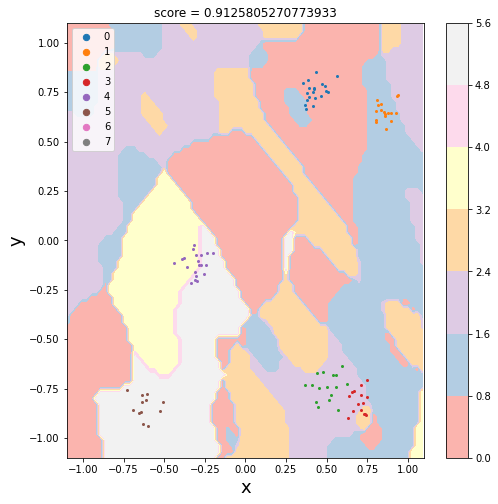

0.9125805270773933

In [42]:
q_fit(n_c=6)

>>> Directional classification learning


100%|██████████| 3/3 [00:38<00:00, 12.83s/it]


>>> Relabeling


100%|██████████| 100/100 [00:04<00:00, 20.20it/s]


>>> Scoring


100%|██████████| 100/100 [00:04<00:00, 20.56it/s]



>>>>>> quantum score =  0.896280949311433
>>> Plotting


100%|██████████| 74/74 [04:20<00:00,  3.52s/it]


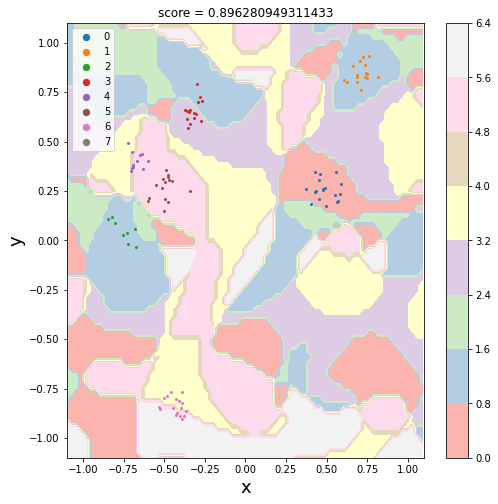

0.896280949311433

In [46]:
q_fit(n_c=7)

>>> Directional classification learning


100%|██████████| 3/3 [00:38<00:00, 12.85s/it]


>>> Relabeling


100%|██████████| 100/100 [00:05<00:00, 19.84it/s]


>>> Scoring


100%|██████████| 100/100 [00:05<00:00, 19.98it/s]



>>>>>> quantum score =  0.8480926088488114
>>> Plotting


100%|██████████| 74/74 [04:25<00:00,  3.59s/it]


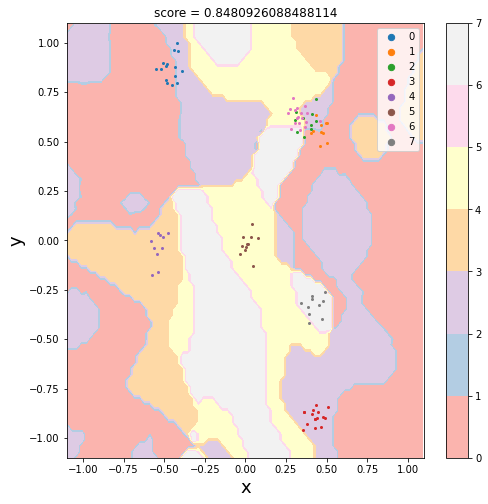

0.8480926088488114

In [19]:
q_fit(n_c=8)

#### Application to Obesity data set

We apply our method to a real problem. We rely on <a href="http://archive.ics.uci.edu/ml/datasets/Estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition+#">this obesity database</a> from the article <a href="https://www.sciencedirect.com/science/article/pii/S2352340919306985?via%3Dihub">Palechor, F. M., & de la Hoz Manotas, A. (2019). Dataset for estimation of obesity levels based on eating habits and physical condition in individuals from Colombia, Peru and Mexico. Data in Brief, 104344 </a>.

The database contains data on different individuals such as their ages, their mobility and their gender. This information is used in order to predict their weight. In particular, people are divided into seven classes: Insufficient Weight, Normal Weight, Overweight Level I, Overweight Level II, Obesity Type I, Obesity Type II and Obesity Type III.

This is the following list of attributes used for the classification:

- Gender
- Age
- Height
- Weight
- Family history with overweight
- Frequent high caloric food consumption
- Vegetables consumption in meals
- Number of daily meals
- Eating between meals
- Smoking
- Consumption of water
- Calories monitoring
- Frequency of physical activity
- Time spent on technological device
- Frequency of alcohol consumption
- Means of transportation

As one can see below, we get excellent results with our method. On the one hand, this means that our method can give results on real databases. On the other hand, the aforementioned attributes are very efficient for obesity prediction.

In [35]:
def normalizeX(z):
        """
        Sets the values between -1 and 1 linearly
        """
        zmax = np.max(z)
        zmin = np.min(z)
        return 2 * (z - zmin) / (zmax - zmin) - 1
    
def normalizey(z):
    global dict_class
    dict_class=redef_class(n_c)
    res = []
    for i in range(len(z)):
        res.append(deepcopy(dict_class[z[i]]))
    return np.array(res)

In [36]:
X = normalizeX(np.genfromtxt("Database/ObesityDataSet_raw_and_data_sinthetic.arff", skip_header=0, usecols=[i for i in range(16)]))
d = len(X[0])
n_c = 7
y = normalizey(np.genfromtxt("Database/ObesityDataSet_raw_and_data_sinthetic.arff", skip_header=0, usecols=[16]))

prop1 = int(len(X) * .8)
prop2 = int(len(X) * .9)
X_train = X[:prop1]
y_train = y[:prop1]

X_relab = X[prop1:prop2]
y_relab = y[prop1:prop2]

X_test = X[prop2:]
y_test = y[prop2:]

In [91]:
gamma = 5
R = 20
c_opt_val_list = []

In [92]:
print(">>> Directional classification learning")
for i in tqdm(range(len(dict_class[0]))): # classification for each direction
    w = []
    b = []
    for _ in range(R):
        temp1, temp2 = random_parameter("normal", d)
        w.append(temp1)
        b.append(temp2)
        
    c_opt_val_list.append(c_opt(qZ(X_train), y_train[:, i])) # train in order to learn c_opt
relab(X_relab, y_relab, c_opt_val_list) # changing labels
# score computation + taking the root
ret = pow(q_score(X_test, y_test, c_opt_val_list), 1 / len(dict_class[0])) 
print("\n>>>>>> quantum score = ", ret)

>>> Directional classification learning


100%|██████████| 3/3 [01:22<00:00, 27.62s/it]


>>> Relabeling


100%|██████████| 211/211 [00:10<00:00, 19.58it/s]


>>> Scoring


100%|██████████| 212/212 [00:10<00:00, 19.51it/s]


>>>>>> quantum score =  0.930865103822622


##### Comparaison with a classical classifier

We compare our classifier with a natural multi-class classifier. As one can see, ```Random Forest``` gets better results than our heuristic. This is of course not surprising at all.

In [37]:
from sklearn.ensemble import RandomForestClassifier

In [38]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

In [41]:
clf.score(X_test,y_test)**(1/np.log2(n_c))

0.998317219589709

#### University Internet Firewall Dataset

For this second example, we use <a href="http://archive.ics.uci.edu/ml/datasets/Internet+Firewall+Data">this database</a> concerning the internet traffic records on a university's firewall. The database uses the following attributes:


where Action is used as the class. It can take the following four values which are converted into integers:

1. allow: 0
2. deny: 1
3. drop: 2
4. reset-both: 3

In [42]:
X = normalizeX(np.genfromtxt("Database/internet.txt", skip_header=0, usecols=[i for i in range(4)] + [i for i in range(5, 12)]))
d = len(X[0])
n_c = 4
y = normalizey(np.genfromtxt("Database/internet.txt", skip_header=0, usecols=[4]))

prop1 = int(len(X) * .8)
prop2 = int(len(X) * .9)
X_train = X[:prop1]
y_train = y[:prop1]

X_relab = X[prop1:prop2]
y_relab = y[prop1:prop2]

X_test = X[prop2:]
y_test = y[prop2:]

In [102]:
gamma = 5
R = 20
c_opt_val_list = []

In [100]:
print(">>> Directional classification learning")
for i in tqdm(range(len(dict_class[0]))): # classification for each direction
    w = []
    b = []
    for _ in range(R):
        temp1, temp2 = random_parameter("normal", d)
        w.append(temp1)
        b.append(temp2)
        
    c_opt_val_list.append(c_opt(qZ(X_train), y_train[:, i])) # train in order to learn c_opt
relab(X_relab, y_relab, c_opt_val_list) # changing labels
# score computation + taking the root
ret = pow(q_score(X_test, y_test, c_opt_val_list), 1 / len(dict_class[0])) 
print("\n>>>>>> quantum score = ", ret)

>>> Directional classification learning


100%|██████████| 2/2 [28:18<00:00, 849.13s/it]


>>> Relabeling


100%|██████████| 6553/6553 [03:50<00:00, 28.41it/s]


>>> Scoring


100%|██████████| 6554/6554 [03:51<00:00, 28.35it/s]


>>>>>> quantum score =  0.7429867395095081


In [43]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

In [44]:
clf.score(X_test,y_test)**(1/np.log2(n_c))

0.9953354744727896